# Homework 2.

Salette Guadalupe Noemi Villalobos A01246619

Erick Hernández Silva A01750170

Israel Sánchez Miranda A01378705

Loading imports and necessary libraries.

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from collections import deque
from tqdm import tqdm

# Region growing algorithm.

# Region Growing Algorithm: Explanation and Implementation

## What is the Region Growing Algorithm?

The region growing algorithm is a pixel-based image segmentation method. The algorithm starts from a **seed point** (a manually selected pixel) and expands the region by examining the neighboring pixels. It adds pixels to the region if they meet certain criteria, such as being similar to the seed pixel in terms of intensity or color. This method is especially useful for segmenting images where regions are clearly distinguishable by their pixel values.

### Steps in the Region Growing Algorithm

1. **Initialization**: Choose a seed point in the image, which will be the starting pixel for the region.
2. **Region Expansion**: Check neighboring pixels of the seed. If a neighboring pixel has a similar value (based on some similarity criterion, such as color intensity), it is added to the region.
3. **Stopping Criterion**: The algorithm stops when no more neighboring pixels meet the similarity condition.
4. **Output**: The segmented region is returned, containing all the pixels that satisfy the similarity criteria.

### Mathematical Representation

Let $S$ be the set of segmented pixels and $p_0$ be the seed pixel. The algorithm evaluates neighboring pixels $p$ based on a similarity function $f(p, p_0)$:

$$
S = \{ p \in I \ | \ f(p, p_0) \leq T \}
$$

Where:
- $I$ is the image
- $f(p, p_0)$ is a distance function (e.g., Euclidean distance in color space)
- $T$ is a predefined threshold for similarity

### Implementation

The implementation consists of:
- **Input**: The function takes an image and a seed point (the starting pixel).
- **Similarity Check**: The algorithm compares the intensity of neighboring pixels to the seed. If the difference is less than the threshold, the pixel is added to the region.
- **Stopping Criterion**: The process continues until all possible neighboring pixels have been evaluated and no more can be added to the region.

This approach works well when the object to be segmented has distinct boundaries and pixel intensities that are similar within the object.


In [9]:
def region_growing(image, seed, threshold=15):
    # Get dimensions of the image
    height, width = image.shape[:2]
    
    # Create an empty mask to hold the segmented region
    segmented = np.zeros((height, width), np.uint8)
    
    # Get the seed point values
    seed_value = image[seed[1], seed[0]]

    # Use deque for faster popping of elements from the front
    pixel_list = deque([seed])

    # Define the 8-connectivity neighbors (up, down, left, right, and diagonals)
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1), (-1, 1), (1, -1)]

    # Total number of pixels to process for the progress bar
    total_pixels = width * height

    # Initialize tqdm progress bar
    with tqdm(total=total_pixels, desc="Region Growing Progress", unit="pixels") as pbar:
        while len(pixel_list) > 0:
            x, y = pixel_list.popleft()  # Use deque's popleft for efficient removal

            # Check if the pixel is within image boundaries and not already segmented
            if x < 0 or y < 0 or x >= width or y >= height or segmented[y, x] == 255:
                pbar.update(1)
                continue

            # Check the intensity similarity using the Euclidean distance for color images
            if np.linalg.norm(image[y, x] - seed_value) < threshold:
                segmented[y, x] = 255  # Mark as part of the region
                for neighbor in neighbors:
                    pixel_list.append((x + neighbor[0], y + neighbor[1]))

            # Update the progress bar
            pbar.update(1)

    return segmented

We then run the code by using a ball image with two regions.

In [26]:
SEGM_IMG = './testing-images/growing.png'

Region Growing Progress:   0%|          | 161/1048576 [00:00<00:06, 160437.86pixels/s]
Region Growing Progress: 3664633pixels [00:03, 1001865.59pixels/s]                        
Region Growing Progress: 3664665pixels [00:03, 928230.55pixels/s]                         
Region Growing Progress: 3665849pixels [00:03, 977030.12pixels/s]                         
Region Growing Progress: 7219801pixels [00:06, 1049557.99pixels/s]                        


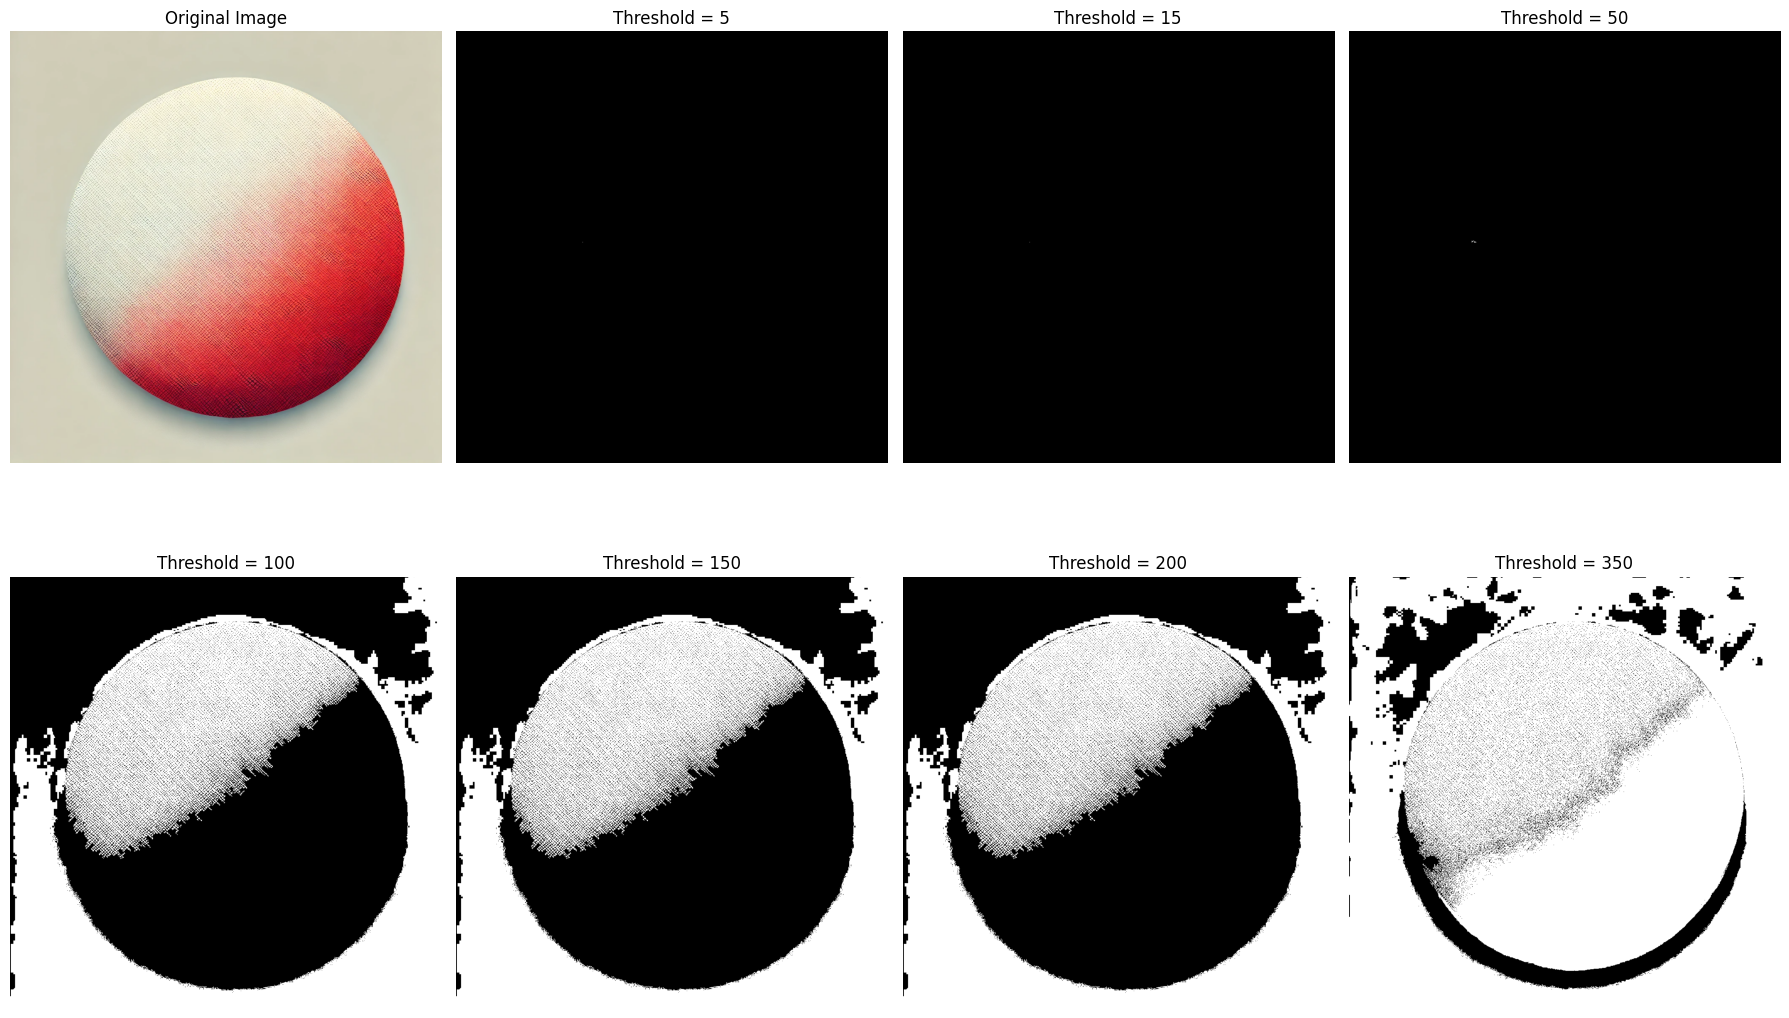

In [40]:
# Load the image
image = cv2.imread(SEGM_IMG)

# Convert the image to RGB (for matplotlib plotting)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Set a seed (x, y) for region growing
seed = (300, 500)

# Define thresholds to be tested
thresholds = [5, 15, 50, 100, 150, 200, 350]  # 7 different thresholds

# Set up a plot with 2 rows and 4 columns to show original image and 7 results
plt.figure(figsize=(18, 12))

# Plot the original image in the first subplot
plt.subplot(2, 4, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

# Loop over the thresholds and apply region growing
for i, threshold in enumerate(thresholds):
    # Run the region growing algorithm for each threshold
    segmented_image = region_growing(image, seed, threshold)
    
    # Plot the segmented image
    plt.subplot(2, 4, i + 2)  # Start from the second subplot
    plt.imshow(segmented_image, cmap='gray')
    plt.title(f"Threshold = {threshold}")
    plt.axis("off")

# Show the plots
plt.tight_layout()
plt.show()

As we can see in the results, the segmented image worked well eventhough we have several image shadings and color changes. The threshold must be, in this case, high because of the intensity changes, as lower thresholds may lead to bad segmentations, as seen in the previous example, where the only pixel starting point seems to have no similar neighbors. Also, too high thresholds leads to missegmentation results. Thus, we have to find an optimal threshold.

# Clustering algorithms for color images.

## K-means clustering


K-means clustering is a method used to partition data into $k$ distinct clusters based on feature similarity. In image segmentation, it groups the pixels of the image into clusters based on their color values. Each pixel is assigned to the cluster whose mean color value is closest to the pixel's color value. The output image is segmented so that each pixel in a cluster takes on the mean color of that cluster.

### Steps in the K-means Clustering Algorithm

1. **Initialization**: Choose $k$ initial centroids (randomly or using a heuristic).
2. **Assignment Step**: Each pixel is assigned to the cluster whose centroid is closest, typically by minimizing the Euclidean distance.
3. **Update Step**: The centroids are recalculated as the mean of all pixels assigned to each cluster.
4. **Convergence**: The algorithm repeats the assignment and update steps until the centroids no longer change significantly.

### Mathematical Representation

Given a set of pixel values $x_i \in \mathbb{R}^3$ (representing the color values of each pixel), the objective is to partition the pixels into $k$ clusters $C_1, C_2, \ldots, C_k$ by minimizing the following within-cluster sum of squares:

$$
\min \sum_{i=1}^{k} \sum_{x_j \in C_i} \| x_j - \mu_i \|^2
$$

Where:
- $x_j$ is a pixel in cluster $C_i$
- $\mu_i$ is the mean of all pixels in cluster $C_i$
- $\|\cdot\|$ denotes the Euclidean distance

### Implementation

In the implementation:
- **Input**: The function takes an image and a predefined number of clusters $k$.
- **Clustering**: The algorithm clusters pixels based on their RGB values.
- **Output**: Each pixel in the image is replaced with the mean color of its cluster, creating a segmented image.

The algorithm converges when the cluster centroids no longer change significantly after an iteration, leading to a segmented version of the input image where regions are grouped by color similarity.



In [29]:
def kmeans_segmentation(image, k=3):
    # Convert image to a 2D array of pixels
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Define criteria and apply KMeans
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert centers to uint8
    centers = np.uint8(centers)

    # Flatten labels to assign the mean color to each pixel
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)

    return segmented_image



After defining the function, we start testing using the testing image sample.

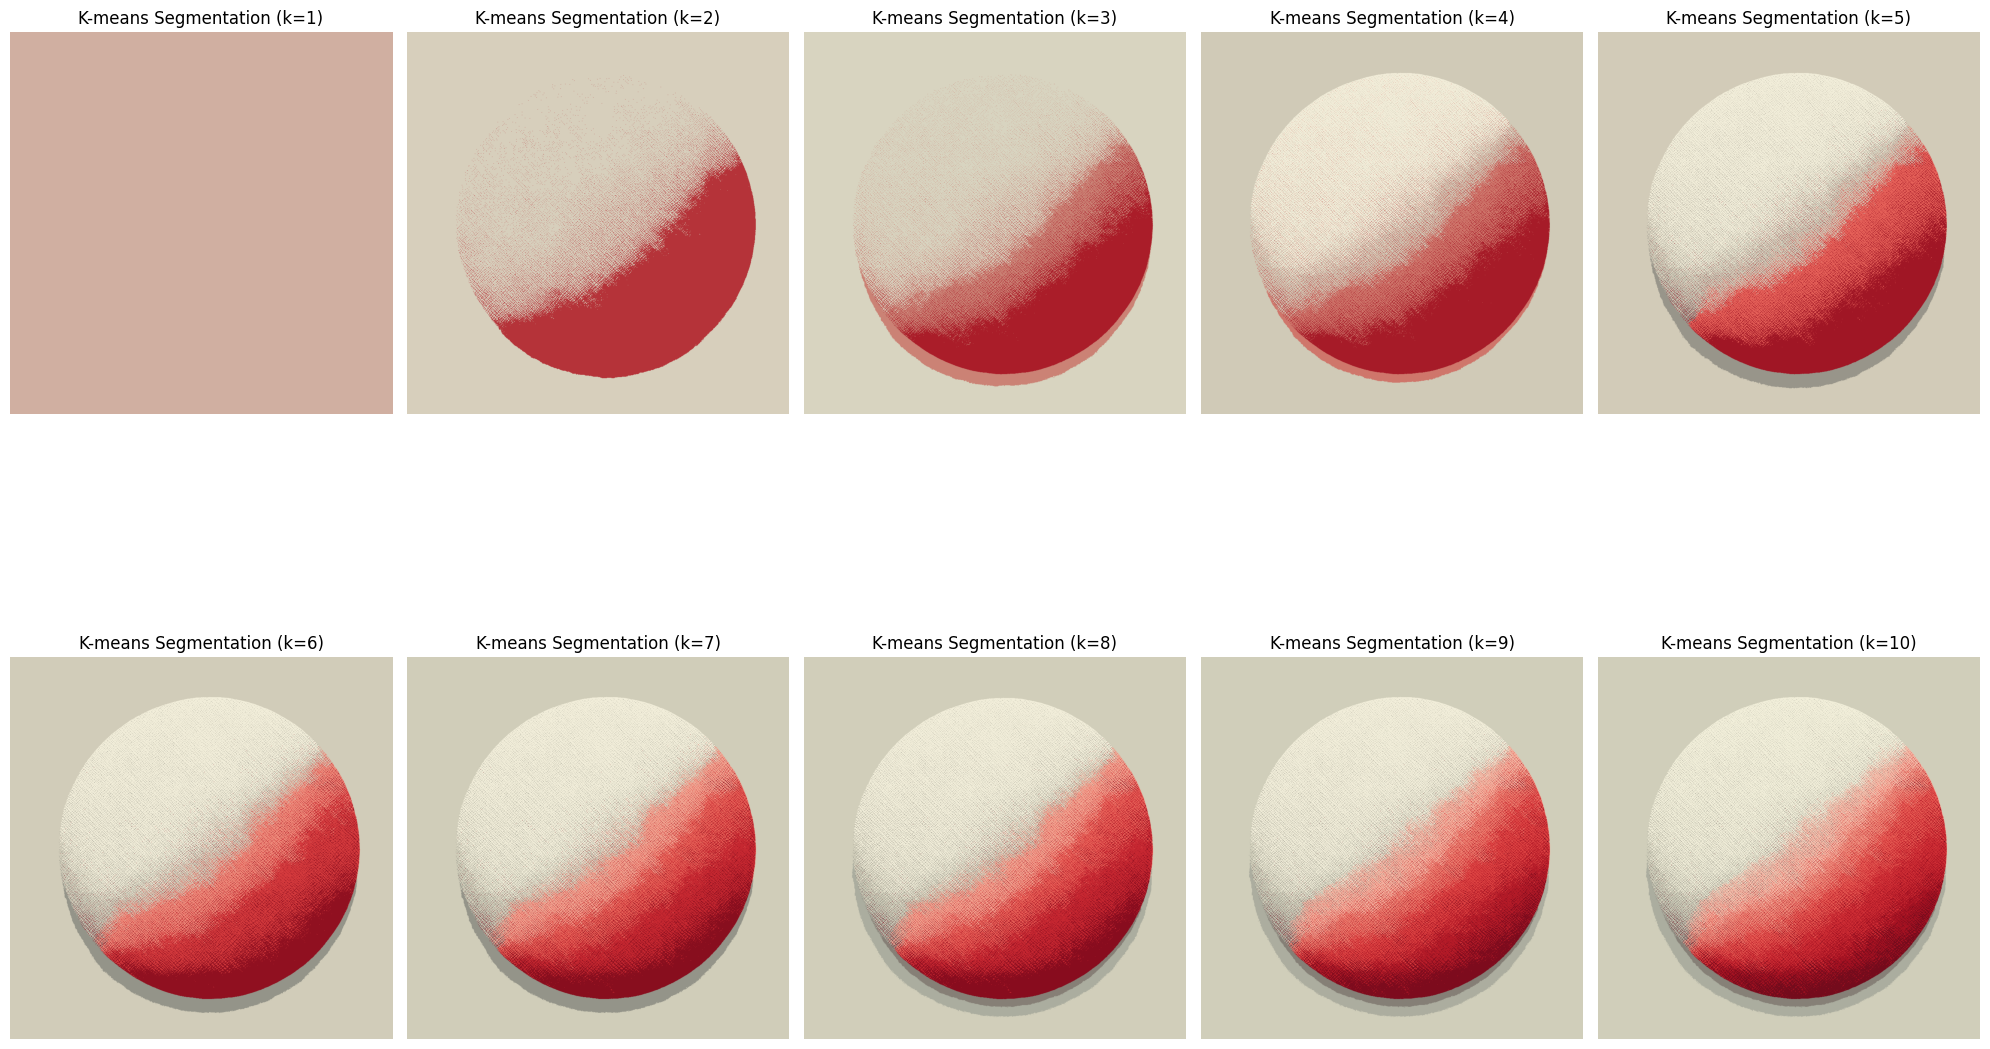

In [36]:
image = cv2.imread(SEGM_IMG)

# Convert the image to RGB (for matplotlib plotting)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Set up a plot with multiple subplots to show results for k = 1 to 10
plt.figure(figsize=(20, 15))

# Loop over k values from 1 to 10
for k in range(1, 11):
    # Apply k-means clustering
    segmented_image = kmeans_segmentation(image, k=k)
    
    # Plot the segmented image
    plt.subplot(2, 5, k)  # Create a 2x5 grid of subplots
    plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
    plt.title(f"K-means Segmentation (k={k})")
    plt.axis("off")

# Show the plots
plt.tight_layout()
plt.show()


The results of K-means clustering show how the segmentation quality changes as the number of clusters $k$ increases from 1 to 10. Below are the main observations:

### Low $k$ Values ($k = 1$ to $k = 3$)
- For $k = 1$, the entire image is segmented into a single color (the average color of the image), which results in no segmentation at all. This happens because K-means treats the entire image as one cluster, as expected.
- As $k$ increases to 2 and 3, the segmentation starts to differentiate the two main color regions of the image (red and white). The separation is still rough, with visible boundaries but limited complexity.

### Moderate $k$ Values ($k = 4$ to $k = 6$)
- With $k = 4$, the segmentation becomes more refined, and the red and white parts of the image are separated more cleanly. The transition between the red and white areas becomes smoother.
- As $k$ increases to 5 and 6, the segmentation captures even more of the gradients in the image, especially around the boundaries of the red circle. The clusters begin to capture more subtle variations in the colors, leading to a more natural segmentation.

### High $k$ Values ($k = 7$ to $k = 10$)
- With higher $k$ values (7 and above), the segmentation becomes more granular. The image starts to break down into many smaller color regions, capturing fine details of the gradient.
- However, as $k$ approaches 10, the image may start to look over-segmented, as the algorithm creates many small regions that might not be necessary for understanding the image. This can sometimes introduce noise into the segmentation.



## Fuzzy C-Means clustering


Fuzzy C-means (FCM) clustering is a method similar to K-means, but with a key difference: in FCM, each data point (or pixel) can belong to multiple clusters with varying degrees of membership, rather than being assigned to only one cluster. This allows for a "fuzzier" segmentation where pixels can belong to more than one region.

In image segmentation, FCM groups pixels based on their color values, assigning each pixel a membership value to different clusters. The final segmented image is based on the pixel's highest membership value, and each pixel's color is relaced by the mean color of the cluster it mostly belongs to.

### Steps in the Fuzzy C-means Clustering Algorithm

1. **Initialization**: Choose $k$ cluster centers randomly and assign fuzzy membership values for each pixel to each cluster.
2. **Fuzzy Membership Update**: Update the membership values of each pixel based on its distance from each cluster center.
3. **Cluster Center Update**: Recalculate the cluster centers using the weighted average of the pixels, where the weights are the membership values.
4. **Convergence**: Repeat steps 2 and 3 until the cluster centers stabilize.

### Mathematical Representation

Let $x_i \in \mathbb{R}^3$ represent the color value of each pixel, and let $u_{ij}$ be the membership of pixel $x_j$ in cluster $C_i$. The objective function to be minimized is:

$$
J_m = \sum_{i=1}^{k} \sum_{j=1}^{n} u_{ij}^m \| x_j - \mu_i \|^2
$$

Where:
- $u_{ij}$ is the membership of pixel $x_j$ in cluster $C_i$
- $m$ is the fuzziness exponent (typically $m = 2$)
- $\mu_i$ is the centroid of cluster $C_i$
- $\|\cdot\|$ denotes the Euclidean distance
- $n$ is the total number of pixels

The membership values $u_{ij}$ are updated using the following formula:

$$
u_{ij} = \frac{1}{\sum_{l=1}^{k} \left( \frac{\| x_j - \mu_i \|}{\| x_j - \mu_l \|} \right)^{\frac{2}{m-1}}}
$$

And the cluster centers $\mu_i$ are updated as:

$$
\mu_i = \frac{\sum_{j=1}^{n} u_{ij}^m x_j}{\sum_{j=1}^{n} u_{ij}^m}
$$

### Implementation

In the implementation:
- **Input**: The function takes an image and the number of clusters $k$.
- **Fuzziness**: Each pixel has a degree of belonging to multiple clusters based on its color.
- **Output**: Each pixel is assigned to the cluster where it has the highest membership, and the pixel's color is replaced by the mean color of that cluster.

This method is particularly effective for images where objects have overlapping or ambiguous boundaries, as pixels can belong to multiple clusters with varying degrees of membership.


In [47]:
import numpy as np
import cv2
import skfuzzy as fuzz

def fuzzy_c_means_segmentation(image, c=3, m=2.0):
    # Reshape image into 2D array of pixels
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Normalize pixel values
    pixel_values /= 255.0

    # Transpose data for fuzzy c-means input
    pixel_values = pixel_values.T

    # Perform fuzzy C-means clustering
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(pixel_values, c, m, error=0.005, maxiter=1000, init=None)

    # Assign each pixel to the cluster with the highest membership
    cluster_labels = np.argmax(u, axis=0)

    # Map each cluster label to the mean color of that cluster
    segmented_image = np.zeros((pixel_values.shape[1], 3))

    for i in range(c):
        # Calculate the mean of each cluster
        mean_color = np.mean(pixel_values[:, cluster_labels == i], axis=1) * 255.0
        segmented_image[cluster_labels == i] = mean_color

    # Reshape back to original image dimensions
    segmented_image = segmented_image.reshape(image.shape)

    return np.uint8(segmented_image)


Now, we can test the algorithm using the test image.

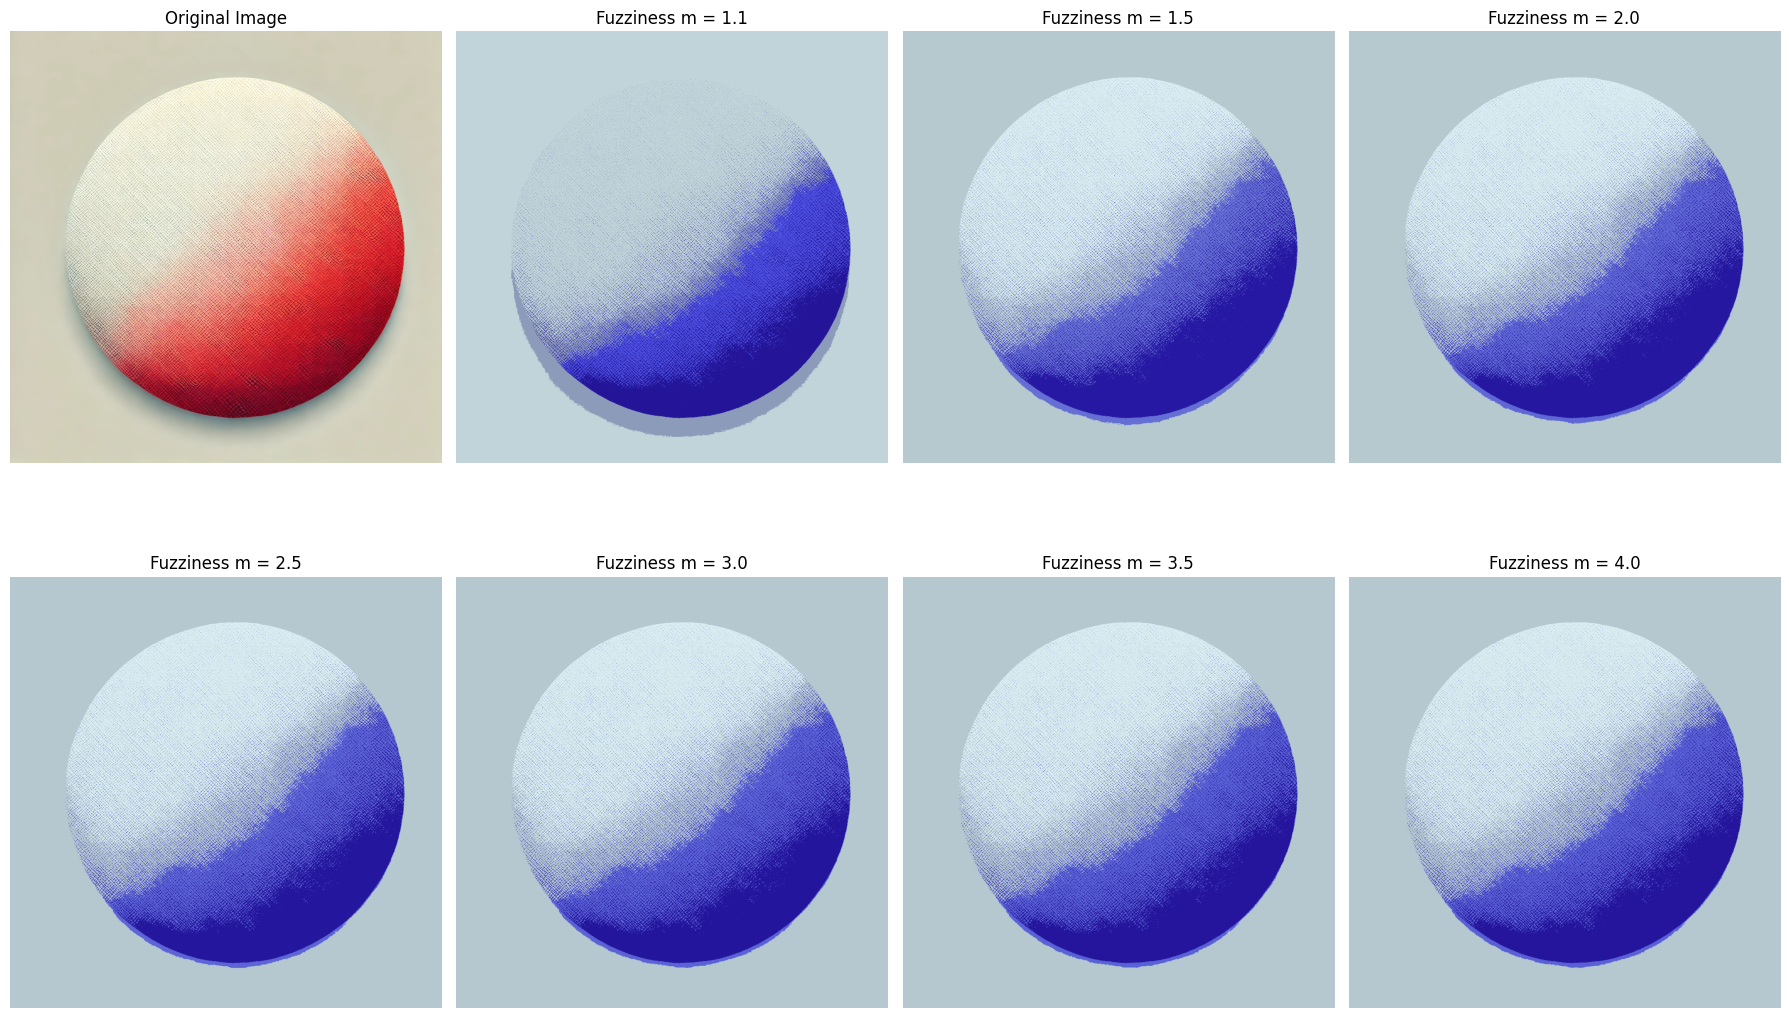

In [48]:
image = cv2.imread(SEGM_IMG)

# Convert the image to RGB (for matplotlib plotting)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define fuzziness parameters (m values) to be tested
fuzziness_params = [1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]  # 7 different m values

# Set up a plot with 2 rows and 4 columns to show original image and 7 results
plt.figure(figsize=(18, 12))

# Plot the original image in the first subplot
plt.subplot(2, 4, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

# Loop over the fuzziness parameter values (m) and apply fuzzy C-means
for i, m in enumerate(fuzziness_params):
    # Run the fuzzy C-means algorithm for each fuzziness parameter m
    segmented_image = fuzzy_c_means_segmentation(image, c=4, m=m)
    
    # Plot the segmented image
    plt.subplot(2, 4, i + 2)  # Start from the second subplot
    plt.imshow(segmented_image)
    plt.title(f"Fuzziness m = {m}")
    plt.axis("off")

# Show the plots
plt.tight_layout()
plt.show()

With the previous plot, we can then see clear differences in segmentation quality as the fuzziness parameter $m$ changes:

### Low Fuzziness Values ($m = 1.1$ to $m = 1.5$)
These values produce **sharper transitions** between clusters, with more defined and rigid boundaries. The red and white parts of the original image are segmented into distinct regions with minimal overlap.
At $m = 1.1$, for example, the clustering is almost binary, creating very clear and abrupt segmentation, which may not capture subtle gradients or transitions in the image.

### Moderate Fuzziness Values ($m = 2.0$ to $m = 2.5$)
These values strike a balance between sharpness and softness. The segmentation shows smooth but still discernible transitions between regions.
The changes in the segmentation are **more natural**, particularly in areas with gradual color transitions. These values provide a good compromise between strictly separated regions and soft blending.

### High Fuzziness Values ($m = 3.0$ to $m = 4.0$)
As $m$ increases, the clusters become **less distinct**, and the boundaries between different regions become more blurred.
This fuzzier segmentation means that more pixels are shared between clusters, resulting in a **softer transition** between colors. This could be useful for images where boundaries are not well-defined, but it reduces the clarity of segmentation for images with clear object boundaries.


# Otsu algorithm.

The Otsu algorithm is a segmentation technique to separate the pixels of an image in two classes: the bakground and the object or first plane. Ths algortm finds the best threshold that minimizes the intra-class variance and maximizes the inter-class variance. This threshold will diide the pixels in two groups in such a way that the difference between the background and the object or first plane is the most.

Otsu has the following steps:
1. Calculate the pixel intensity histogram of the input image.
2. Calculate the cumulative probability for each intensity.
3. Obtain the cumulative median for the intensities.
4. For each intensity calculate the intra and inter-class variance.
5. Choose an optimal threshold value that minimizes intra-class variance (make pixels of this class as similar as possible) and maximizes inter-class variance (make pixels of other classes as different as possible).

To implement it in Python we first read an image in grayscale and use the `cv2.threshold` function over the image to apply the Otsu algorithm. We define the boundaries used in the histogram (`0` and `255` for intensities in grayscale images). And use a binary and Otsu thresholds to segmentate the image.

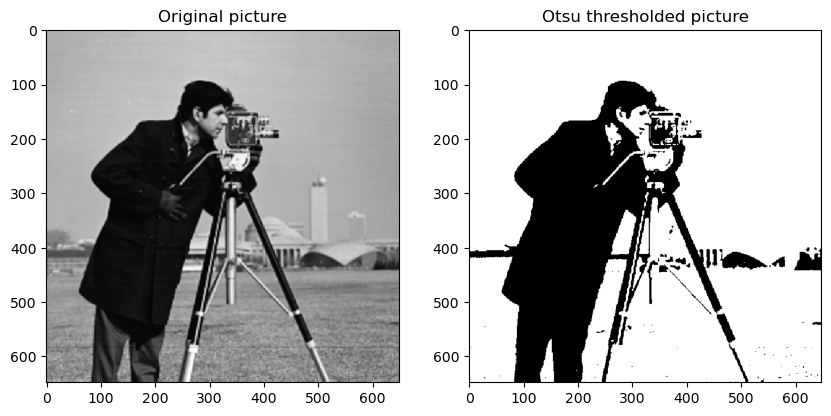

In [2]:
# Read image in grayscale
img = cv2.imread('cameraman.png', 0)

# Apply Otsu
_, otsu_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Show original and threshold image
plt.figure(figsize=(10, 5))

# Original picture
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original picture')

# Otsu picture
plt.subplot(1, 2, 2)
plt.imshow(otsu_img, cmap='gray')
plt.title('Otsu thresholded picture')

plt.show()

As we can see in the result, the original picture has different intensities in the grayscale domain. After using the Otsu algorithm this different intesities are discarded and we remain with a binary image with two classes: black and white pixels.

However, using Otsu algorithm isn't enough for correct segmentation. Particularly, this algorithm has two main weaknesses: If an image presents too much noise, Otsu will have trouble assignin a class to each pixel due to the high variation of intensity values. The other disadvantage of this algorithm is that if applied to an image where the background and the first plane or object have pixels with similar intensities (i.e. a blue object in a blue background) Otsu will have it hard to find an optimal treshold for segmentation.

To solve the first problem it is possible to apply morphological operators to reduce noise or fill gaps within objects. We first define a function `clean_segmentation` that will apply an opening or closing to the Otsu thresholded image to either reduce the noise (if opening operation is chosen) or to fill gaps within objects of the same class (if closing operation is chosen). we use the `cv2.morphologyEx` function to apply either the opening or closing function to the image, then we return the clean image.

In [3]:
def clean_segmentation(img, operation, kernel_size=(5, 5)):
    # Create a kernel for morphological operation
    kernel = np.ones(kernel_size, np.uint8)
    
    # Check which operation to apply
    if operation == 'opening':
        # Apply opening (erosion then dilation)
        clean_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    elif operation == 'closing':
        # Apply closing (dilation then erosion)
        clean_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    else:
        raise ValueError("Operation must be 'opening' or 'closing'.")
    
    return clean_img

We apply the function to the thresholded image and appreciate the results. The opening allows to extend the border of the object up to the noisy sections in order to reduce it while the closing completely reduces the noise around the object due to the dilation followed by the erosion.

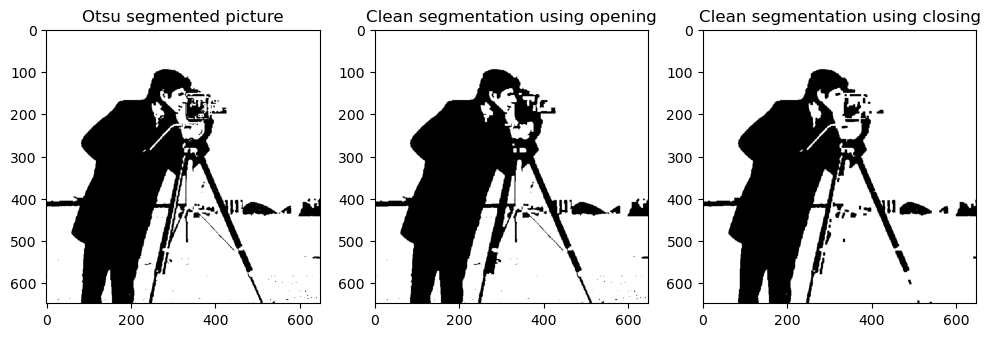

In [4]:
# Clean Otsu image with 'opening'
otsu_opening_img = clean_segmentation(otsu_img, 'opening')

# Clean Otsu image with 'closing'
otsu_closing_img = clean_segmentation(otsu_img, 'closing')

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(otsu_img, cmap='gray')
plt.title('Otsu segmented picture')

plt.subplot(1, 3, 2)
plt.imshow(otsu_opening_img, cmap='gray')
plt.title('Clean segmentation using opening')

plt.subplot(1, 3, 3)
plt.imshow(otsu_closing_img, cmap='gray')
plt.title('Clean segmentation using closing')

plt.show()

## Distance map for Otsu

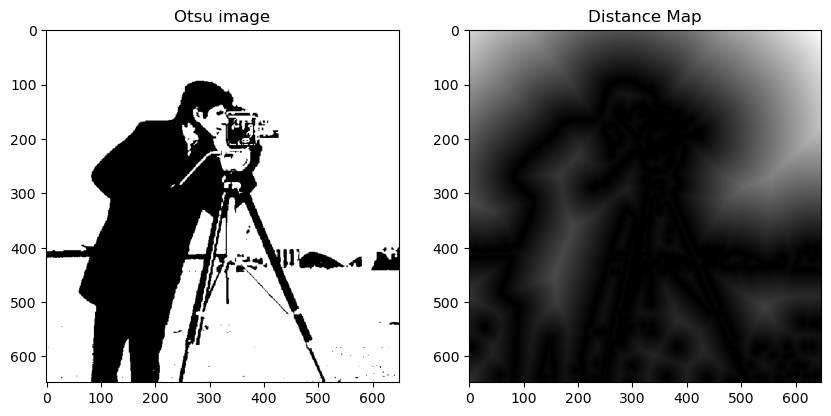

In [5]:
# Find the object boundaries (edges)
edges = cv2.Canny(otsu_img, 100, 200)

# Compute the distance map from the object boundaries
# Use the distance transform, where we treat the edge pixels as the '0' or boundary
distance_map = distance_transform_edt(~edges)

# Display the results
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(otsu_img, cmap='gray')
plt.title('Otsu image')

plt.subplot(1, 2, 2)
plt.imshow(distance_map, cmap='gray')
plt.title('Distance Map')
plt.show()

# Skeleton algorithm

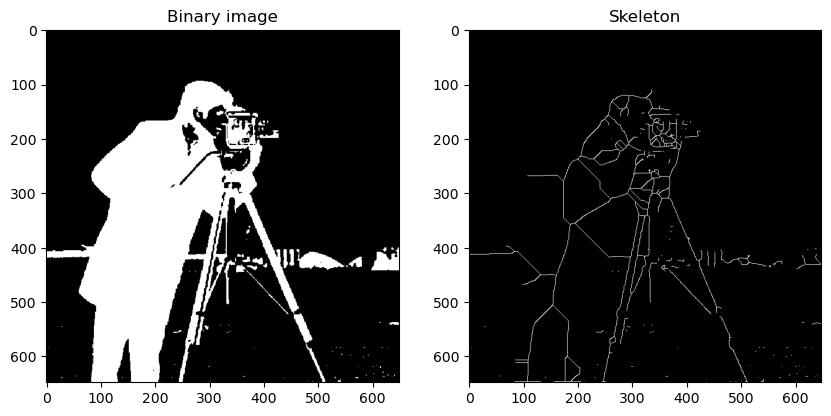

In [6]:
# Invert the binary image (object is white, background is black)
inverted = 255 - otsu_img

# Perform skeletonization using OpenCV's thinning function
skeleton = cv2.ximgproc.thinning(inverted)

# Display the results
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(inverted, cmap='gray')
plt.title('Binary image')

plt.subplot(1, 2, 2)
plt.imshow(skeleton, cmap='gray')
plt.title('Skeleton')
plt.show()


# Optical flow

# Segmentation pipeline.